# Avito Data Exploration

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import textblob

from collections import Counter

In [2]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [3]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

## Helper Fuctions

In [4]:
def translate_to_english(text):
    decode_text = text.decode('UTF-8')
    translated_text = textblob.TextBlob(decode_text).translate(to='en')
    return str(translated_text)

## Load Train and Test Data

In [5]:
train_df = pd.read_csv(train_csv_path)

In [6]:
test_df = pd.read_csv(test_csv_path)

In [7]:
print 'Shape of train_df:', train_df.shape
print 'Shape of test_df:', test_df.shape

Shape of train_df: (1503424, 18)
Shape of test_df: (508438, 17)


In [8]:
print train_df.columns.values

['item_id' 'user_id' 'region' 'city' 'parent_category_name'
 'category_name' 'param_1' 'param_2' 'param_3' 'title' 'description'
 'price' 'item_seq_number' 'activation_date' 'user_type' 'image'
 'image_top_1' 'deal_probability']


## Exploring item_id and user_id Fields:

In [25]:
# Get overlap of item_id in train and test sets
train_item_id = np.array(list(set(train_df.item_id.values)))
test_item_id = np.array(list(set(test_df.item_id.values)))
item_intersect= np.intersect1d(train_item_id, test_item_id)
print 'Number of common entries in item_id field:', len(item_intersect)

Number of common entries in item_id field: 0


In [26]:
# Get overlap of user_id in train and test sets
train_user_id = np.array(list(set(train_df.user_id.values)))
test_user_id = np.array(list(set(test_df.user_id.values)))
user_intersect = np.intersect1d(train_user_id, test_user_id)
print 'Number of common entries in user_id field:', len(user_intersect)

Number of common entries in user_id field: 67929


In [28]:
print 'Ratio of shared elements in train set:', len(user_intersect)/float(len(train_user_id))
print 'Ratio of shared elements in test set:', len(user_intersect)/float(len(test_user_id))

Ratio of shared elements in train set: 0.0880172694161
Ratio of shared elements in test set: 0.22194015075


What this shows is that roughly 8.8% of the training set is repeated in the test set. This portion represents 22% of the test set (which is an appreciably large number).

## Exploring "region" Field:

In [34]:
train_regions_set = np.array(list(set(train_df.region.values)))
test_regions_set = np.array(list(set(test_df.region.values)))
regions_intersect = np.intersect1d(train_regions_set, test_regions_set)
print 'Number of regions in training set:', len(train_regions_set) 
print 'Number of regions in test set:', len(test_regions_set) 
print 'Number of shared regions between both sets:', len(regions_intersect) 

Number of regions in training set: 28
Number of regions in test set: 28
Number of shared regions between both sets: 28


In [36]:
translated_regions = [translate_to_english(region) for region in regions_intersect]

In [39]:
regions_dict = {}
for i, region in enumerate(regions_intersect):
    regions_dict[region] = translated_regions[i]

In [40]:
def region_lookup(regions, lookup):
    translated_list = []
    for region in regions:
        translated_list.append(lookup[region])
    return(translated_list)

In [42]:
translated_regions_train = region_lookup(train_df.region.values, regions_dict)
translated_regions_test = region_lookup(test_df.region.values, regions_dict)

In [44]:
train_regions_sizes = Counter(translated_regions_train)
test_regions_sizes = Counter(translated_regions_test)

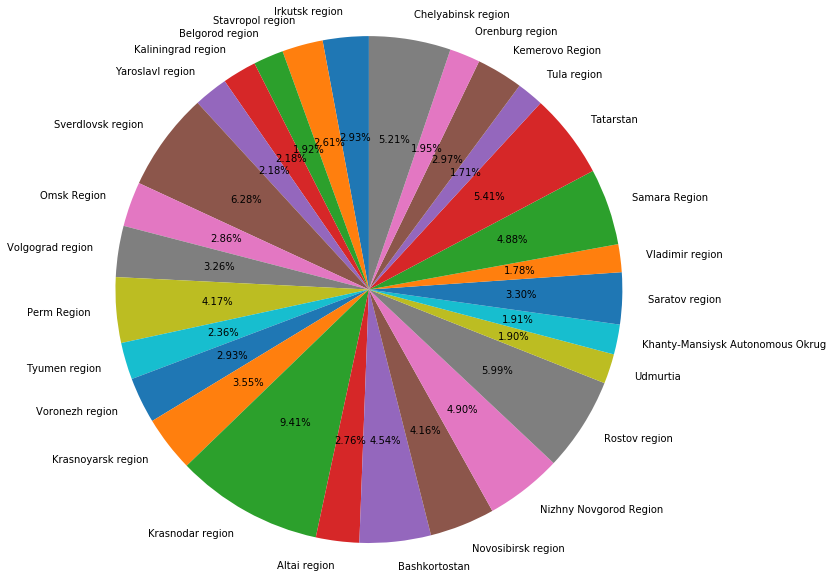

In [56]:
# Visualize train distribution
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([float(val)/len(translated_regions_train) for val in train_regions_sizes.values()], 
        labels=[lab for lab in train_regions_sizes], startangle=90, autopct='%1.2f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [74]:
# Compare train and test region distribution 
train_test_region = {}
for region in translated_regions:
    train_test_region[region] = [train_regions_sizes[region], test_regions_sizes[region]]
region_eval_df = pd.DataFrame.from_dict(train_test_region, orient='index')
region_eval_df.columns = ['train', 'test']
region_eval_df['train_percent'] = 100*np.divide(region_eval_df.train, float(len(translated_regions_train)))
region_eval_df['test_percent'] = 100*np.divide(region_eval_df.test, float(len(translated_regions_test)))
region_eval_df['abs_percent_diff'] = np.abs(region_eval_df.train_percent - region_eval_df.test_percent)

In [76]:
print 'Maximum percent difference in distribution between train and test:', np.amax(region_eval_df.abs_percent_diff)

Maximum percent difference in distribution between train and test: 0.7401319317258901


### Making "region" population dictionary

In [77]:
translated_regions

['Altai region',
 'Bashkortostan',
 'Belgorod region',
 'Vladimir region',
 'Volgograd region',
 'Voronezh region',
 'Irkutsk region',
 'Kaliningrad region',
 'Kemerovo Region',
 'Krasnodar region',
 'Krasnoyarsk region',
 'Nizhny Novgorod Region',
 'Novosibirsk region',
 'Omsk Region',
 'Orenburg region',
 'Perm Region',
 'Rostov region',
 'Samara Region',
 'Saratov region',
 'Sverdlovsk region',
 'Stavropol region',
 'Tatarstan',
 'Tula region',
 'Tyumen region',
 'Udmurtia',
 'Khanty-Mansiysk Autonomous Okrug',
 'Chelyabinsk region',
 'Yaroslavl region']

#### Coordinate Representation:
1 degree = 60 minutes (conversion factor)
* Longitutude:
    * East (negative)
    * West (positive)
* Latitude:
    * North (positive)
    * South (negative)

Key below: population, latitude (degrees, minutes), longitude (degrees, minutes), area (km2)

In [81]:
region_metadata = \
[[206168, 50, 55, -86, -55, 92600], [4072292, 54, 28, -56, -16, 143600], [1532526, 50, 46, -37, -27, 27100], 
 [1443693, 56, 5, -40, -37, 29000], [2610161, 49, 44, -44, -7, 113900], [2331100, 51, 3, -40, -9, 52400], 
 [2428750, 57, 22, -106, 0, 767900], [941873, 54, 48, -21, -25, 15100], [2763135, 54, 56, -87, -14, 95500],
 [5226647, 45, 22, -39, -26, 76000], [2828187, 59, 53, -91, -40, 2339700], [3310597, 56, 29, -44, -32, 76900],
 [2665911, 55, 27, -79, -33, 178200], [1977665, 56, 13, -73, -16, 139700], [2033072, 52, 8, -55, -36, 124000], 
 [2635276, 59, 14, -56, -8, 160600], [4277976, 47, 52, -41, -11, 100800], [3215532, 53, 27, -50, -27, 53600], 
 [2521892, 51, 47, -46, -44, 100200], [4297747, 58, 42, -61, -20, 194800], [2786281, 45, 3, -43, -16, 66500],
 [3786488, 55, 33, -50, -56, 68000], [1553925, 53, 55, -37, -35, 25700], [3395755, 57, 50, -69, 0, 1435200], 
 [1521420, 57, 17, -52, -45, 42100], [1532243, 62, 15, -70, -10, 534800], [3476217, 54, 32, -60, -20, 87900], 
 [1272468, 57, 52, -39, -12, 36400]]